<a href="https://colab.research.google.com/github/monanasim/project-/blob/main/assigment_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 83.9 MB/s eta 0:00:00:00:010:01
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 67.1 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.9 MB/s eta 0:00:0000:01


Using device: cpu

Dataset Information:
Name: Cora
Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7
Training nodes: 140
Validation nodes: 500
Test nodes: 1000

Starting training...
Epoch: 010, Loss: 0.0300, Val Acc: 0.7680
Epoch: 020, Loss: 0.0005, Val Acc: 0.7460

Early stopping at epoch 27


/tmp/ipykernel_31/176769509.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


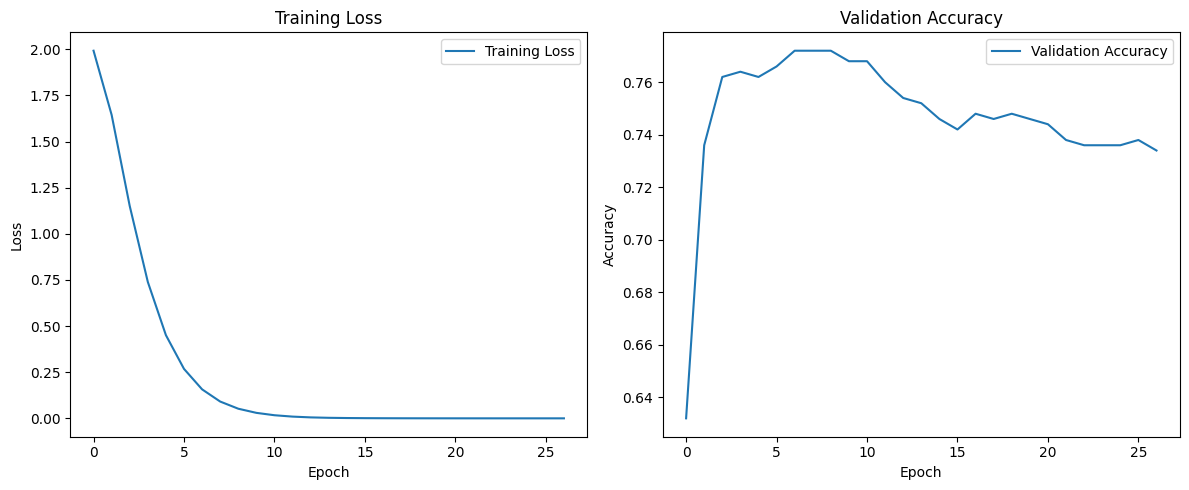


Final Test Accuracy: 0.7840

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.82      0.70       130
           1       0.77      0.87      0.82        91
           2       0.85      0.90      0.88       144
           3       0.94      0.68      0.79       319
           4       0.74      0.83      0.78       149
           5       0.80      0.72      0.76       103
           6       0.68      0.83      0.75        64

    accuracy                           0.78      1000
   macro avg       0.77      0.81      0.78      1000
weighted avg       0.81      0.78      0.79      1000



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

dataset = Planetoid(root='/kaggle/working/Cora', name='Cora')
data = dataset[0].to(device)

# Print dataset information
print("\nDataset Information:")
print(f"Name: {dataset.name}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features: {data.num_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Training nodes: {data.train_mask.sum().item()}")
print(f"Validation nodes: {data.val_mask.sum().item()}")
print(f"Test nodes: {data.test_mask.sum().item()}")

class GAT(nn.Module):
    def __init__(self, num_features, num_classes, hidden_dim=64, heads=8, dropout=0.6):
        super(GAT, self).__init__()
        self.dropout = dropout

        self.conv1 = GATConv(
            num_features,
            hidden_dim,
            heads=heads,
            dropout=dropout
        )


        self.conv2 = GATConv(
            hidden_dim * heads,
            num_classes,
            heads=1,
            concat=False,
            dropout=dropout
        )

    def forward(self, x, edge_index):

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index))


        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

model = GAT(
    num_features=data.num_features,
    num_classes=dataset.num_classes,
    hidden_dim=64,
    heads=8
).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()


def train(model, data, epochs=200, patience=20):
    model.train()
    best_val_acc = 0
    patience_counter = 0
    train_losses = []
    val_accuracies = []

    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())


        val_acc = evaluate(model, data, data.val_mask)
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch}")
            break

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')


    model.load_state_dict(torch.load('best_model.pth'))
    return train_losses, val_accuracies


def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = (pred[mask] == data.y[mask]).sum()
        acc = int(correct) / int(mask.sum())
    return acc


def plot_training(train_losses, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

print("\nStarting training...")
train_losses, val_accuracies = train(model, data)

plot_training(train_losses, val_accuracies)

test_acc = evaluate(model, data, data.test_mask)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

from sklearn.metrics import classification_report
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1) print("\nClassification Report:")
print("\nClassification Report:")
print(classification_report(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu()))